In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
ss = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [3]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [5]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
textID           27481 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27481 non-null object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
train.dropna(inplace=True)

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
textID       3534 non-null object
text         3534 non-null object
sentiment    3534 non-null object
dtypes: object(3)
memory usage: 83.0+ KB


In [9]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,8bb353dccb,THANKS!,good,neutral
freq,1,1,199,11117


In [10]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


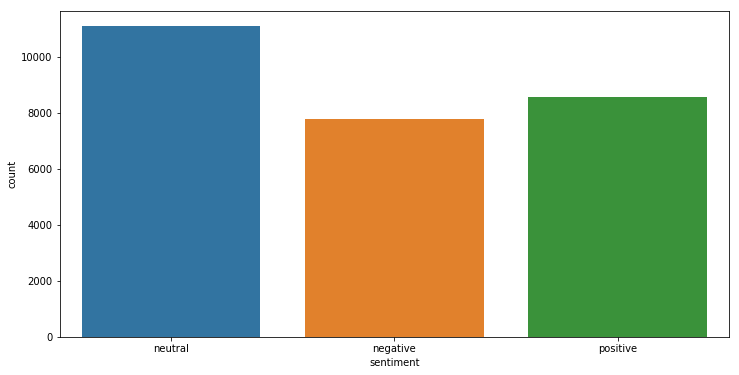

In [11]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [12]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

* Difference In Number Of words of Selected_text and Text
* Jaccard Similarity Scores between text and Selected_text

In [13]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [14]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [15]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard)

In [16]:
jaccard

,text,selected_text,jaccard_score
0,"I`d have responded, if I were going","I`d have responded, if I were going",1.000000
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0.200000
2,my boss is bullying me...,bullying me,0.166667
3,what interview! leave me alone,leave me alone,0.600000
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0.214286
...,...,...,...
27475,wish we could come see u on Denver husband l...,d lost,0.058824
27476,I`ve wondered about rake to. The client has ...,", don`t force",0.083333
27477,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,0.272727
27478,But it was worth it ****.,But it was worth it ****.,1.000000


In [17]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286


In [18]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [19]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


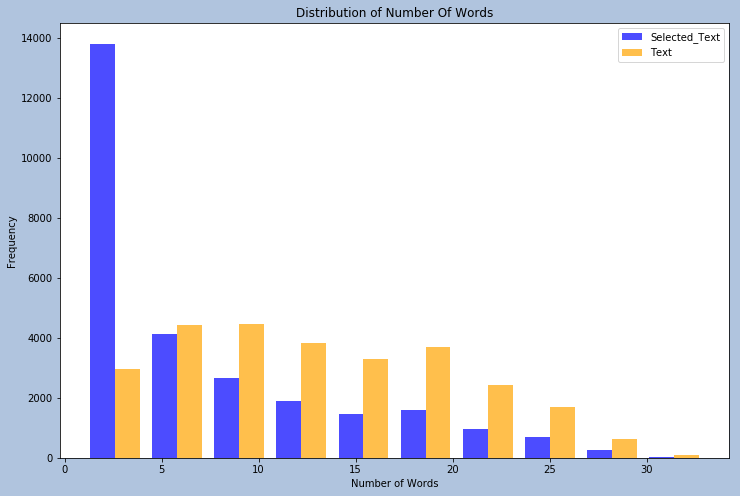

In [20]:
hist_data = [train['Num_words_ST'], train['Num_word_text']]
group_labels = ['Selected_Text', 'Text']
plt.figure(figsize=(12, 8))
plt.hist(hist_data, bins=10, label=group_labels, color=['blue', 'orange'], alpha=0.7)
plt.title('Distribution of Number Of Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.gcf().set_facecolor('lightsteelblue')
plt.show()

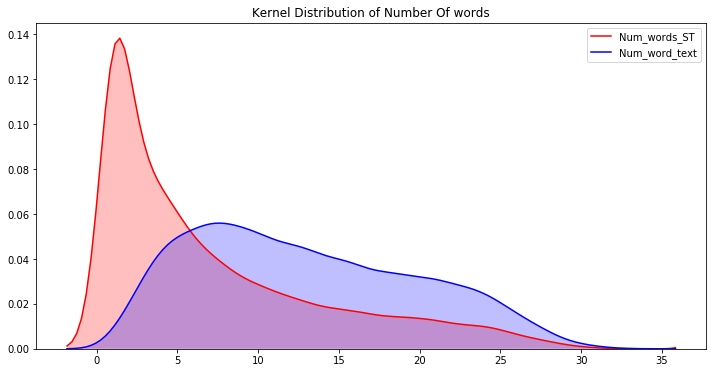

In [21]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

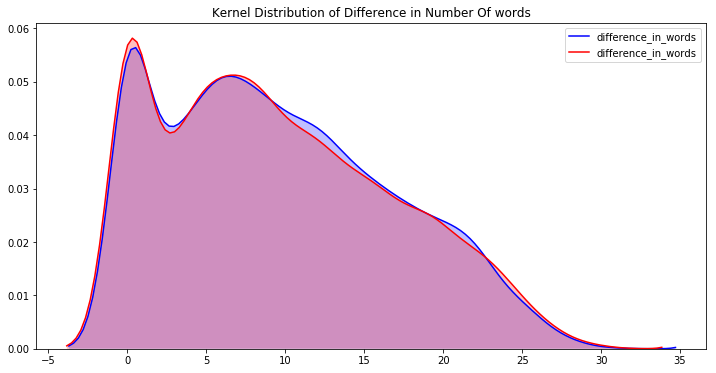

In [22]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

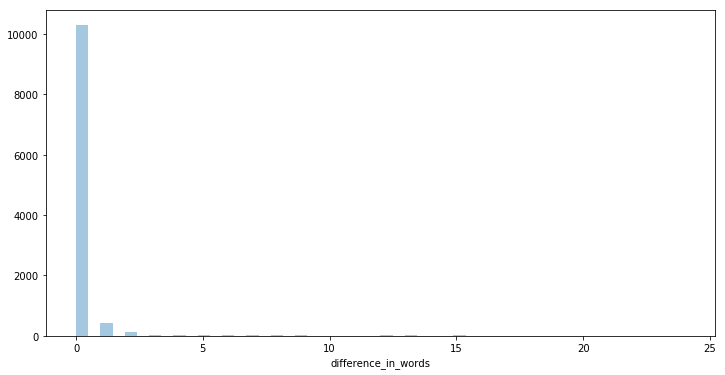

In [23]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

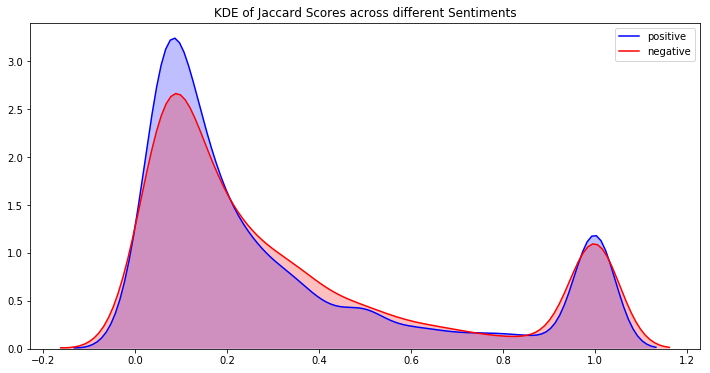

In [24]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

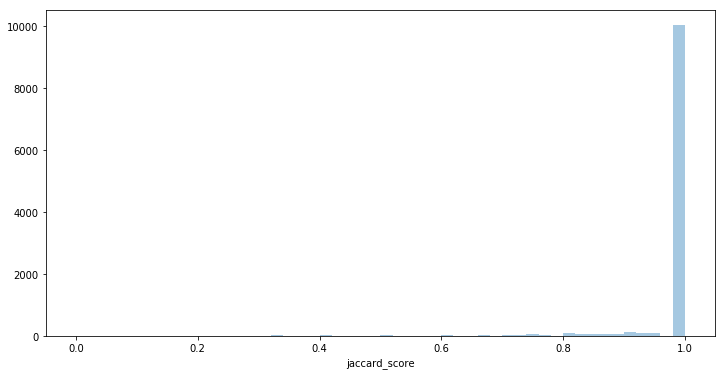

In [25]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

## Conclusion Of EDA

* We can see from the jaccard score plot that there is peak for negative and positive plot around score of 1 .That means there is a cluster of tweets where there is a high similarity between text and selected texts ,if we can find those clusters then we can predict text for selected texts for those tweets irrespective of segment

Let's see if we can find those clusters,one interesting idea would be to check tweets which have number of words lesss than 3 in text, because there the text might be completely used as text

In [26]:
k = train[train['Num_word_text']<=2]

In [27]:
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

We can see that there is similarity between text and selected text .Let's have closer look

In [28]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


Thus its clear that most of the times , text is used as selected text.We can improve this by preprocessing the text which have word length less than 3.We will remember this information and use it in model building

### Cleaning the Corpus
Now Before We Dive into extracting information out of words in text and selected text, let's first clean the data

In [29]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [30]:
train['text'] = train['text'].apply(clean_text)
train['selected_text'] = train['selected_text'].apply(clean_text)

In [31]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


### Most Common words in our Target-Selected Text

In [32]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
word_counts = Counter()

for sublist in train['temp_list']:
    for word in sublist:
        word_counts[word] += 1


temp = pd.DataFrame(word_counts.most_common(20))
temp.columns = ['Common_words','count']
temp

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [33]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [34]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

train['temp_list'] = train['temp_list'].apply(remove_stopword)

In [35]:
word_counts = Counter()

for sublist in train['temp_list']:
    for word in sublist:
        word_counts[word] += 1

temp = pd.DataFrame(word_counts.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [36]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [37]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

### Most Common words in Text

In [38]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(remove_stopword) #Removing Stopwords

In [39]:
word_counts = Counter()

for sublist in train['temp_list1']:
    for word in sublist:
        word_counts[word] += 1

temp = pd.DataFrame(word_counts.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [40]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

So we can see the Most common words in Selected text and Text are almost the same,which was obvious

### Most common words Sentiments Wise

In [41]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [42]:
#MosT common positive words
word_counts = Counter()

for sublist in Positive_sent['temp_list']:
    for word in sublist:
        word_counts[word] += 1
        
temp_positive = pd.DataFrame(word_counts.most_common(20))
temp_positive.columns = ['Common_words','count']

In [43]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [44]:
#MosT common negative words
word_counts = Counter()

for sublist in Negative_sent['temp_list']:
    for word in sublist:
        word_counts[word] += 1
        
temp_negative = pd.DataFrame(word_counts.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']

In [45]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon negative Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [46]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [47]:
#MosT common Neutral words
word_counts = Counter()

for sublist in Neutral_sent['temp_list']:
    for word in sublist:
        word_counts[word] += 1
        
temp_neutral = pd.DataFrame(word_counts.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']

In [48]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [49]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

* We can see words like get, go, dont, got, u, cant, lol, like are common in all three segments. That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature. Does this mean our data is incorrectly labelled?
* It will be interesting to see the word unique to different sentiments

## Let's Look at Unique Words in each Segment

We will look at unique words in each segment in the Following Order:
* Positive
* Negative
* Neutral

In [50]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [51]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..
    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother.append(word)
    allother  = list(set(allother))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

### Positive Tweets

In [52]:
Unique_Positive = words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [53]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

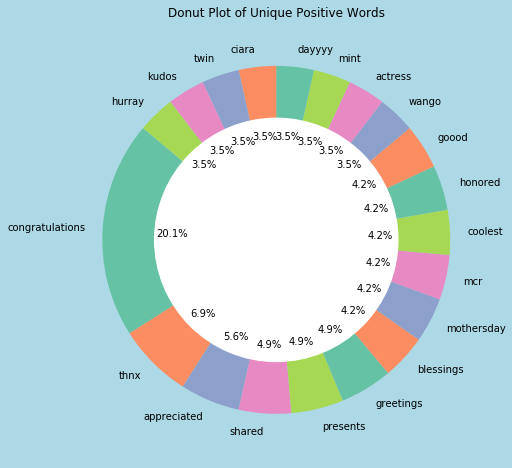

In [54]:
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
plt.figure(figsize=(10, 8), facecolor='lightblue')
plt.pie(Unique_Positive['count'], labels=Unique_Positive['words'], colors=colors, autopct='%1.1f%%', startangle=140)

my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(my_circle)
plt.title('Donut Plot of Unique Positive Words')
plt.show()

In [55]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


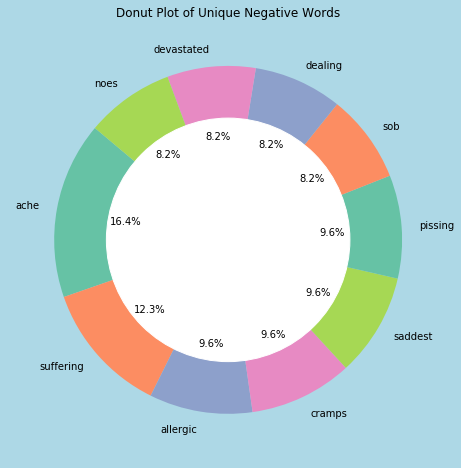

In [56]:
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
plt.figure(figsize=(10, 8), facecolor='lightblue')
plt.pie(Unique_Negative['count'], labels=Unique_Negative['words'], colors=colors, autopct='%1.1f%%', startangle=140)

my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(my_circle)
plt.title('Donut Plot of Unique Negative Words')
plt.show()

In [57]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


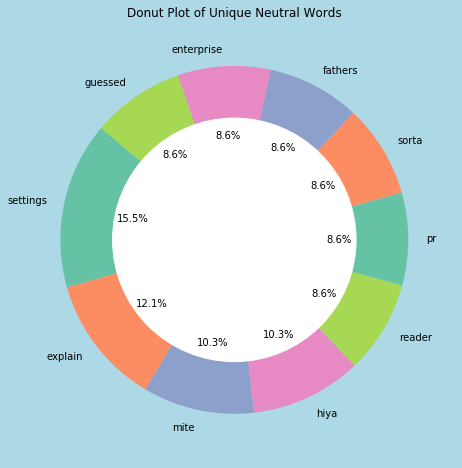

In [58]:
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
plt.figure(figsize=(10, 8), facecolor='lightblue')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral['words'], colors=colors, autopct='%1.1f%%', startangle=140)

my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(my_circle)
plt.title('Donut Plot of Unique Neutral Words')
plt.show()

**By Looking at the Unique Words of each sentiment,we now have much more clarity about the data,these unique words are very strong determiners of Sentiment of tweets**

## It's Time For WordClouds

We will be building wordclouds in the following order:

* WordCloud of Neutral Tweets
* WordCloud of Positive Tweets
* WordCloud of Negative Tweets


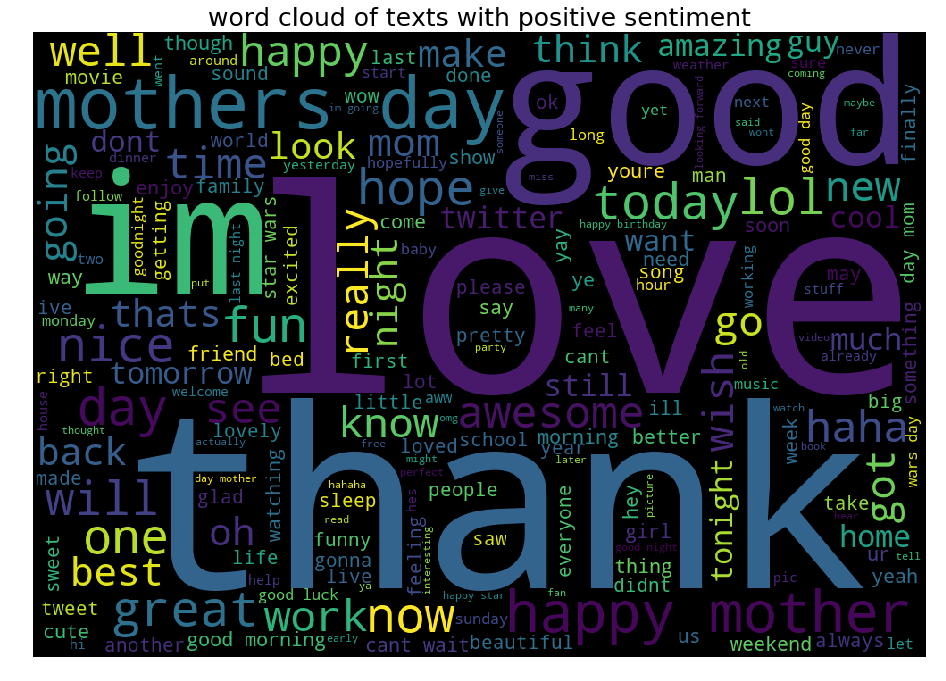

In [63]:
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(Positive_sent.text.astype(str)))
plt.figure(figsize = (16, 14))
plt.title('word cloud of texts with positive sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

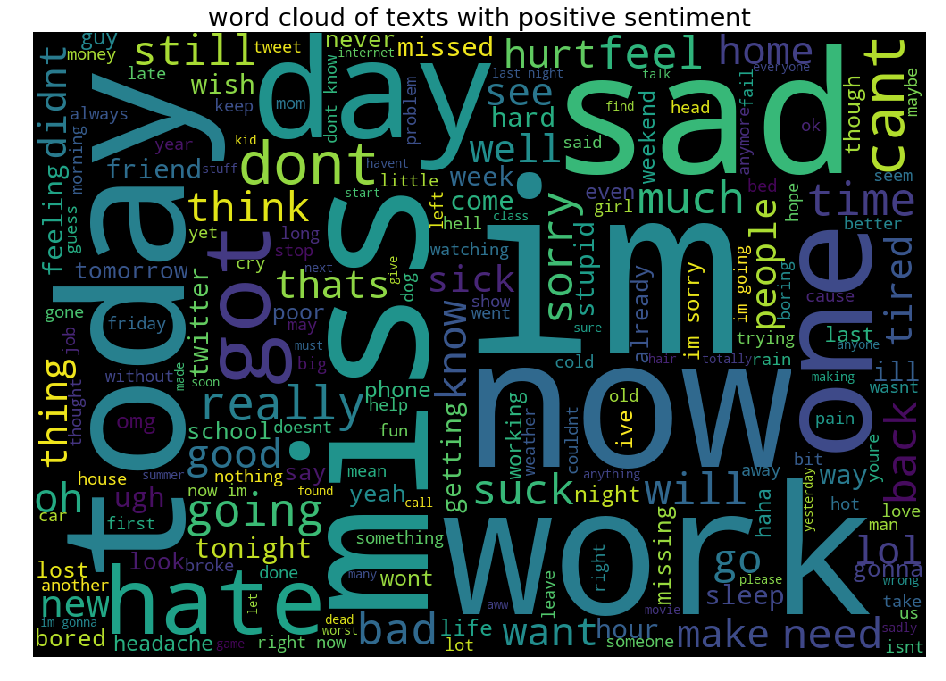

In [64]:
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(Negative_sent.text.astype(str)))
plt.figure(figsize = (16, 14))
plt.title('word cloud of texts with positive sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

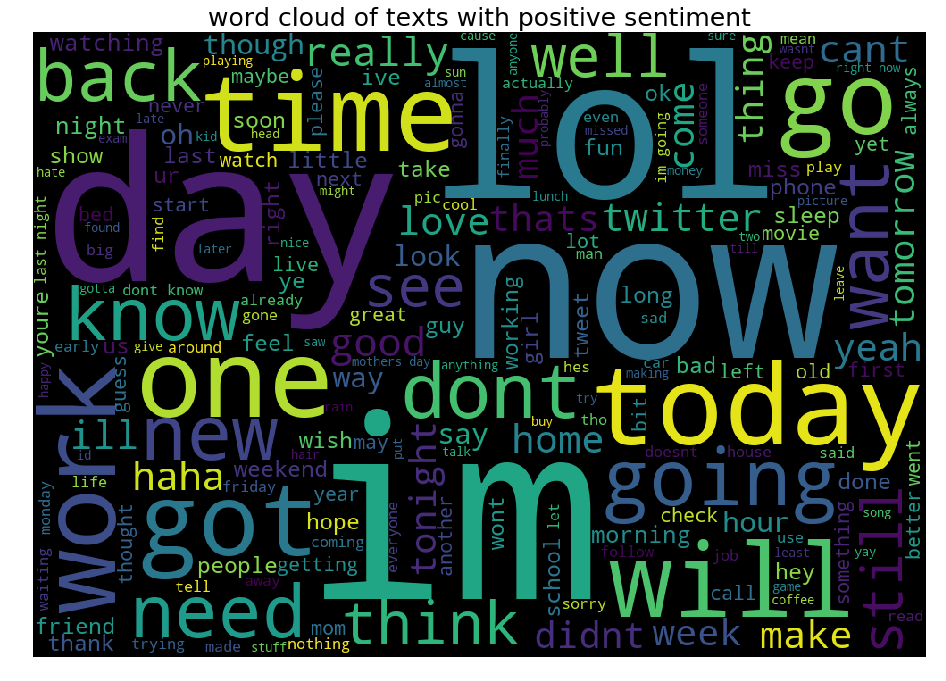

In [65]:
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(Neutral_sent.text.astype(str)))
plt.figure(figsize = (16, 14))
plt.title('word cloud of texts with positive sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

In [66]:
df_train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
df_submission = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [67]:
df_test.head(20)

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
5,726e501993,that`s great!! weee!! visitors!,positive
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative
8,e64208b4ef,and within a short time of the last clue all ...,neutral
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral


In [68]:
df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main Text in train set

In [69]:
df_train = df_train[df_train['Num_words_text']>=3]

In [70]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [71]:
# pass model = nlp if you want to train on top of existing model 

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses, 
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [72]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    return model_out_path

In [73]:
def get_training_data(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

#### Training models for Positive and Negative tweets

In [74]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
# For DEmo Purposes I have taken 3 iterations you can train the model as you want
train(train_data, model_path, n_iter=20, model=None)

  0%|          | 0/20 [00:00<?, ?it/s]

Created blank 'en' model


  5%|▌         | 1/20 [00:46<14:36, 46.15s/it]

Losses {'ner': 33663.49690312435}


 10%|█         | 2/20 [01:31<13:47, 45.95s/it]

Losses {'ner': 30983.418311623504}


 15%|█▌        | 3/20 [02:17<12:58, 45.82s/it]

Losses {'ner': 29428.366385918962}


 20%|██        | 4/20 [03:03<12:16, 46.05s/it]

Losses {'ner': 28482.371500285004}


 25%|██▌       | 5/20 [03:51<11:37, 46.49s/it]

Losses {'ner': 28012.649695401262}


 30%|███       | 6/20 [04:36<10:47, 46.24s/it]

Losses {'ner': 26991.29541190338}


 35%|███▌      | 7/20 [05:22<09:58, 46.03s/it]

Losses {'ner': 26709.73120647279}


 40%|████      | 8/20 [06:13<09:30, 47.53s/it]

Losses {'ner': 26212.718596450573}


 45%|████▌     | 9/20 [07:06<09:00, 49.10s/it]

Losses {'ner': 25931.486019796634}


 50%|█████     | 10/20 [07:59<08:21, 50.20s/it]

Losses {'ner': 25359.419116072495}


 55%|█████▌    | 11/20 [08:51<07:38, 50.99s/it]

Losses {'ner': 24552.265264249654}


 60%|██████    | 12/20 [09:44<06:52, 51.56s/it]

Losses {'ner': 24433.60146610527}


 65%|██████▌   | 13/20 [10:37<06:03, 51.95s/it]

Losses {'ner': 24167.32005068135}


 70%|███████   | 14/20 [11:30<05:13, 52.26s/it]

Losses {'ner': 23465.334429993236}


 75%|███████▌  | 15/20 [12:23<04:22, 52.45s/it]

Losses {'ner': 23890.571880274474}


 80%|████████  | 16/20 [13:16<03:30, 52.50s/it]

Losses {'ner': 22814.951308868498}


 85%|████████▌ | 17/20 [14:08<02:37, 52.60s/it]

Losses {'ner': 22405.623219894936}


 90%|█████████ | 18/20 [15:01<01:45, 52.58s/it]

Losses {'ner': 22613.22139018419}


 95%|█████████▌| 19/20 [15:54<00:52, 52.62s/it]

Losses {'ner': 22679.420660961026}


100%|██████████| 20/20 [16:46<00:00, 50.35s/it]

Losses {'ner': 22143.73808551473}
Saved model to ../working/models/model_pos


In [75]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=20, model=None)

  0%|          | 0/20 [00:00<?, ?it/s]

Created blank 'en' model


  5%|▌         | 1/20 [00:43<13:40, 43.20s/it]

Losses {'ner': 31891.365531250136}


 10%|█         | 2/20 [01:26<12:55, 43.09s/it]

Losses {'ner': 28844.775907222443}


 15%|█▌        | 3/20 [02:08<12:10, 42.94s/it]

Losses {'ner': 27305.440632012906}


 20%|██        | 4/20 [02:51<11:27, 43.00s/it]

Losses {'ner': 25852.239954489254}


 25%|██▌       | 5/20 [03:36<10:52, 43.49s/it]

Losses {'ner': 25075.006896254046}


 30%|███       | 6/20 [04:19<10:08, 43.45s/it]

Losses {'ner': 24344.74501743884}


 35%|███▌      | 7/20 [05:02<09:22, 43.28s/it]

Losses {'ner': 23696.40570443458}


 40%|████      | 8/20 [05:46<08:42, 43.53s/it]

Losses {'ner': 23000.519250431862}


 45%|████▌     | 9/20 [06:36<08:18, 45.28s/it]

Losses {'ner': 22194.904217746607}


 50%|█████     | 10/20 [07:26<07:47, 46.72s/it]

Losses {'ner': 21814.530217087708}


 55%|█████▌    | 11/20 [08:16<07:09, 47.67s/it]

Losses {'ner': 21797.0229762913}


 60%|██████    | 12/20 [09:05<06:26, 48.34s/it]

Losses {'ner': 21542.722567568177}


 65%|██████▌   | 13/20 [09:55<05:41, 48.84s/it]

Losses {'ner': 20816.840144563965}


 70%|███████   | 14/20 [10:45<04:55, 49.17s/it]

Losses {'ner': 20537.88214325247}


 75%|███████▌  | 15/20 [11:35<04:07, 49.40s/it]

Losses {'ner': 20170.287138660653}


 80%|████████  | 16/20 [12:25<03:18, 49.61s/it]

Losses {'ner': 20130.171072110326}


 85%|████████▌ | 17/20 [13:15<02:29, 49.71s/it]

Losses {'ner': 19735.849446292897}


 90%|█████████ | 18/20 [14:05<01:39, 49.80s/it]

Losses {'ner': 19629.24546609081}


 95%|█████████▌| 19/20 [14:55<00:49, 49.84s/it]

Losses {'ner': 19178.13118556687}


100%|██████████| 20/20 [15:45<00:00, 47.29s/it]

Losses {'ner': 19178.371562186585}
Saved model to ../working/models/model_neg


### Predicting with the trained Model

In [76]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [77]:
selected_texts = []
MODELS_BASE_PATH = '../input/tse-spacy-model/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

Loading Models  from  ../input/tse-spacy-model/models/


In [79]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(20))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting
2,eee518ae67,Recession
3,01082688c6,happy bday!
4,33987a8ee5,I like it!!
5,726e501993,visitors!
6,261932614e,HATES
7,afa11da83f,blocked
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...
